# Dataset 1: Transformer based embedding

## Imports and login

In [1]:
import os, re, json, gc, time

import torch
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer

import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
wnl = WordNetLemmatizer()


from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from huggingface_hub import login, logout

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import numpy as np

from matplotlib import pyplot as plt

In [2]:
# transformers.utils.logging.set_verbosity_info()

### Logging in to HuggingFace, downloading the model and reading the dataset

In [3]:
f = open("../hf_token_read", "r")
hf_token = f.read()
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/alkakumari/.cache/huggingface/token
Login successful


In [4]:
# Download the model and tokenizer
model_path = 'Alibaba-NLP/gte-large-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path) #BertTokenizerFast
model = AutoModel.from_pretrained(model_path, trust_remote_code=True) 

In [5]:
david_df = pd.read_pickle('../data/davidson_data.p')
david_df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

## Preprocessing

In [6]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['tweet'] = df['tweet'].apply(lambda x: x.lower()) #lowercase
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['tweet'] = df['tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

In [7]:
MAX_SEQ_LEN = 25

In [8]:
X = david_df.drop(columns=['class'])
Y = david_df['class']
X = clean(X)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)

## Embedding

### X_train

In [9]:
del david_df
del f
del hf_token
del stopwords
del wnl
del X
del Y
gc.collect()

27

In [10]:
token_temp = tokenizer(X_train["tweet"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )

In [11]:
embedding_batch_size = 175
num_batches = len(X_train) // embedding_batch_size + 1
print("Number of batches for training:", num_batches)


Number of batches for training: 114


In [12]:
for i in range(num_batches): 
    if i == 0:
        X_train_batch = X_train[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_train_batch = X_train[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_train))
    else:
        X_train_batch = X_train[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_train_batch["tweet"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_train_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_train_embeddings = tf.convert_to_tensor(X_train_embeddings.detach().numpy())
    if i == 0:
        tf_X_train_embeddings_concatnated = tf_X_train_embeddings
    else:
        tf_X_train_embeddings_concatnated = tf.concat([tf_X_train_embeddings_concatnated, tf_X_train_embeddings], axis=0)
    del X_train_batch
    del token_temp
    del outputs
    del X_train_embeddings
    del tf_X_train_embeddings
    gc.collect()
    time.sleep(1)

Processing batch from 0 to 175
Processing batch from 175 to 350
Processing batch from 350 to 525
Processing batch from 525 to 700
Processing batch from 700 to 875
Processing batch from 875 to 1050
Processing batch from 1050 to 1225
Processing batch from 1225 to 1400
Processing batch from 1400 to 1575
Processing batch from 1575 to 1750
Processing batch from 1750 to 1925
Processing batch from 1925 to 2100
Processing batch from 2100 to 2275
Processing batch from 2275 to 2450
Processing batch from 2450 to 2625
Processing batch from 2625 to 2800
Processing batch from 2800 to 2975
Processing batch from 2975 to 3150
Processing batch from 3150 to 3325
Processing batch from 3325 to 3500
Processing batch from 3500 to 3675
Processing batch from 3675 to 3850
Processing batch from 3850 to 4025
Processing batch from 4025 to 4200
Processing batch from 4200 to 4375
Processing batch from 4375 to 4550
Processing batch from 4550 to 4725
Processing batch from 4725 to 4900
Processing batch from 4900 to 507

In [13]:
tf_X_train_embeddings_concatnated.shape

TensorShape([19826, 1024])

### X_val

In [16]:
num_batches = len(X_val) // embedding_batch_size + 1

In [17]:

for i in range(num_batches): 
    if i == 0:
        X_val_batch = X_val[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_val_batch = X_val[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_train))
    else:
        X_val_batch = X_val[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_val_batch["tweet"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_val_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_val_embeddings = tf.convert_to_tensor(X_val_embeddings.detach().numpy())
    if i == 0:
        tf_X_val_embeddings_concatnated = tf_X_val_embeddings
    else:
        tf_X_val_embeddings_concatnated = tf.concat([tf_X_val_embeddings_concatnated, tf_X_val_embeddings], axis=0)
    del X_val_batch
    del token_temp
    del outputs
    del X_val_embeddings
    del tf_X_val_embeddings
    gc.collect()
    time.sleep(2)

Processing batch from 0 to 175
Processing batch from 175 to 350
Processing batch from 350 to 525
Processing batch from 525 to 700
Processing batch from 700 to 875
Processing batch from 875 to 1050
Processing batch from 1050 to 1225
Processing batch from 1225 to 1400
Processing batch from 1400 to 1575
Processing batch from 1575 to 1750
Processing batch from 1750 to 1925
Processing batch from 1925 to 2100
Processing batch from 2100 to 2275
Processing batch from 2275 to 2450
Processing batch from 2450 to 2625
Processing batch from 2625 to 2800
Processing batch from 2800 to 2975
Processing batch from 2975 to 3150
Processing batch from 3150 to 3325
Processing batch from 3325 to 3500
Processing batch from 3500 to 3675
Processing batch from 3675 to 3850
Processing batch from 3850 to 4025
Processing batch from 4025 to 4200
Processing batch from 4200 to 4375
Processing batch from 4375 to 4550
Processing batch from 4550 to 4725
Processing batch from 4725 to 4900
Processing batch from 4900 to 198

### Weight initialisation

In [18]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

## Training

In [24]:
learning_rate = 0.00003

In [25]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = LSTM(500, return_sequences=True)(text_input)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.7)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [33]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = simpleRNN(500)(text_input)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = GRU(500)(text_input)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['accuracy'])
    return model

In [26]:

def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      mode='min',
                                                      restore_best_weights=True)
      X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
      print(X_train.shape)
      X_val = tf.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, 
            batch_size=batch_size, 
            #class_weight=class_weights,
            callbacks=callback,
            shuffle=True,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
      fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [27]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

(19826, 1, 1024)
Epoch 1/100
155/155 - 4s - loss: 0.5498 - accuracy: 0.8038 - val_loss: 0.3740 - val_accuracy: 0.8679 - 4s/epoch - 29ms/step
Epoch 2/100
155/155 - 3s - loss: 0.3554 - accuracy: 0.8771 - val_loss: 0.3343 - val_accuracy: 0.8792 - 3s/epoch - 18ms/step
Epoch 3/100
155/155 - 3s - loss: 0.3278 - accuracy: 0.8833 - val_loss: 0.3180 - val_accuracy: 0.8848 - 3s/epoch - 19ms/step
Epoch 4/100
155/155 - 3s - loss: 0.3179 - accuracy: 0.8862 - val_loss: 0.3141 - val_accuracy: 0.8856 - 3s/epoch - 19ms/step
Epoch 5/100
155/155 - 3s - loss: 0.3105 - accuracy: 0.8865 - val_loss: 0.3095 - val_accuracy: 0.8858 - 3s/epoch - 19ms/step
Epoch 6/100
155/155 - 3s - loss: 0.3049 - accuracy: 0.8906 - val_loss: 0.3034 - val_accuracy: 0.8876 - 3s/epoch - 19ms/step
Epoch 7/100
155/155 - 4s - loss: 0.2982 - accuracy: 0.8907 - val_loss: 0.3020 - val_accuracy: 0.8880 - 4s/epoch - 25ms/step
Epoch 8/100
155/155 - 3s - loss: 0.2950 - accuracy: 0.8926 - val_loss: 0.2987 - val_accuracy: 0.8899 - 3s/epoch - 2

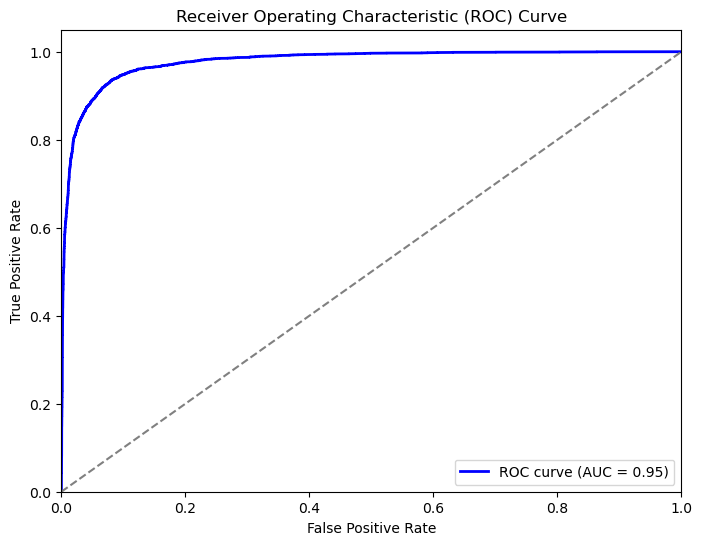

In [29]:
m = model_LSTM(1024)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

(19826, 1, 1024)
Epoch 1/100
155/155 - 1s - loss: 0.9115 - accuracy: 0.7071 - val_loss: 0.4524 - val_accuracy: 0.8426 - 1s/epoch - 7ms/step
Epoch 2/100
155/155 - 1s - loss: 0.5948 - accuracy: 0.8049 - val_loss: 0.3859 - val_accuracy: 0.8660 - 752ms/epoch - 5ms/step
Epoch 3/100
155/155 - 1s - loss: 0.5129 - accuracy: 0.8322 - val_loss: 0.3615 - val_accuracy: 0.8777 - 686ms/epoch - 4ms/step
Epoch 4/100
155/155 - 1s - loss: 0.4851 - accuracy: 0.8406 - val_loss: 0.3589 - val_accuracy: 0.8790 - 655ms/epoch - 4ms/step
Epoch 5/100
155/155 - 1s - loss: 0.4532 - accuracy: 0.8521 - val_loss: 0.3446 - val_accuracy: 0.8806 - 831ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.4450 - accuracy: 0.8536 - val_loss: 0.3442 - val_accuracy: 0.8828 - 722ms/epoch - 5ms/step
Epoch 7/100
155/155 - 1s - loss: 0.4417 - accuracy: 0.8560 - val_loss: 0.3441 - val_accuracy: 0.8834 - 718ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.4243 - accuracy: 0.8589 - val_loss: 0.3357 - val_accuracy: 0.8862 - 7

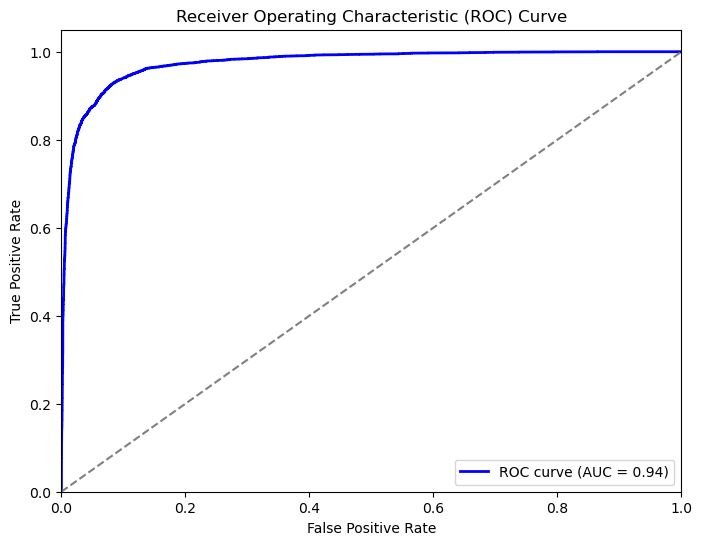

In [34]:
m = model_RNN(1024, input_length=MAX_SEQ_LEN)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

(19826, 1, 1024)
Epoch 1/100
155/155 - 2s - loss: 0.5790 - accuracy: 0.7826 - val_loss: 0.4025 - val_accuracy: 0.8545 - 2s/epoch - 15ms/step
Epoch 2/100
155/155 - 2s - loss: 0.4097 - accuracy: 0.8506 - val_loss: 0.3527 - val_accuracy: 0.8681 - 2s/epoch - 10ms/step
Epoch 3/100
155/155 - 2s - loss: 0.3710 - accuracy: 0.8660 - val_loss: 0.3345 - val_accuracy: 0.8745 - 2s/epoch - 10ms/step
Epoch 4/100
155/155 - 2s - loss: 0.3516 - accuracy: 0.8737 - val_loss: 0.3258 - val_accuracy: 0.8780 - 2s/epoch - 10ms/step
Epoch 5/100
155/155 - 2s - loss: 0.3428 - accuracy: 0.8752 - val_loss: 0.3202 - val_accuracy: 0.8824 - 2s/epoch - 10ms/step
Epoch 6/100
155/155 - 2s - loss: 0.3369 - accuracy: 0.8780 - val_loss: 0.3168 - val_accuracy: 0.8820 - 2s/epoch - 10ms/step
Epoch 7/100
155/155 - 2s - loss: 0.3282 - accuracy: 0.8789 - val_loss: 0.3131 - val_accuracy: 0.8840 - 2s/epoch - 10ms/step
Epoch 8/100
155/155 - 2s - loss: 0.3201 - accuracy: 0.8833 - val_loss: 0.3100 - val_accuracy: 0.8854 - 2s/epoch - 1

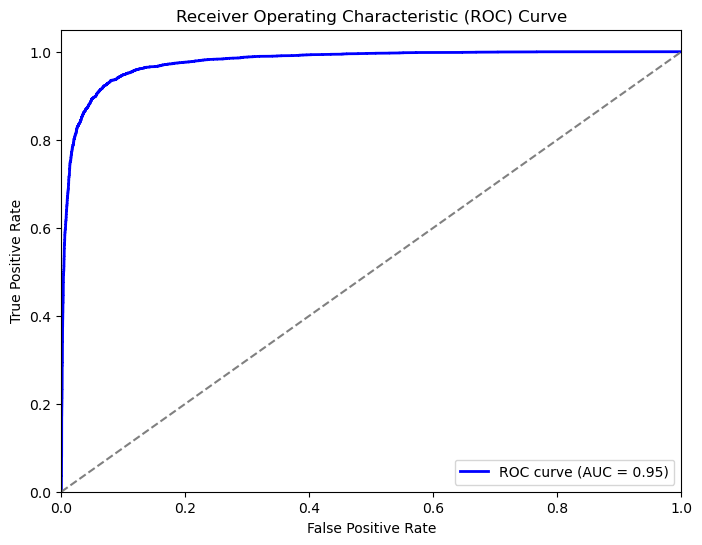

In [37]:
m = model_GRU(1024, input_length=MAX_SEQ_LEN)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

(19826, 1, 1024)
Epoch 1/100
155/155 - 3s - loss: 0.0979 - accuracy: 0.5547 - val_loss: 0.0626 - val_accuracy: 0.7686 - 3s/epoch - 17ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0653 - accuracy: 0.7438 - val_loss: 0.0493 - val_accuracy: 0.7694 - 670ms/epoch - 4ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0545 - accuracy: 0.7800 - val_loss: 0.0417 - val_accuracy: 0.8326 - 655ms/epoch - 4ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0473 - accuracy: 0.8164 - val_loss: 0.0371 - val_accuracy: 0.8596 - 665ms/epoch - 4ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0429 - accuracy: 0.8385 - val_loss: 0.0351 - val_accuracy: 0.8703 - 698ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0404 - accuracy: 0.8457 - val_loss: 0.0342 - val_accuracy: 0.8723 - 692ms/epoch - 4ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0388 - accuracy: 0.8556 - val_loss: 0.0336 - val_accuracy: 0.8733 - 695ms/epoch - 4ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0378 - accuracy: 0.8590 - val_loss: 0.0328 - val_accuracy: 0.8757 - 

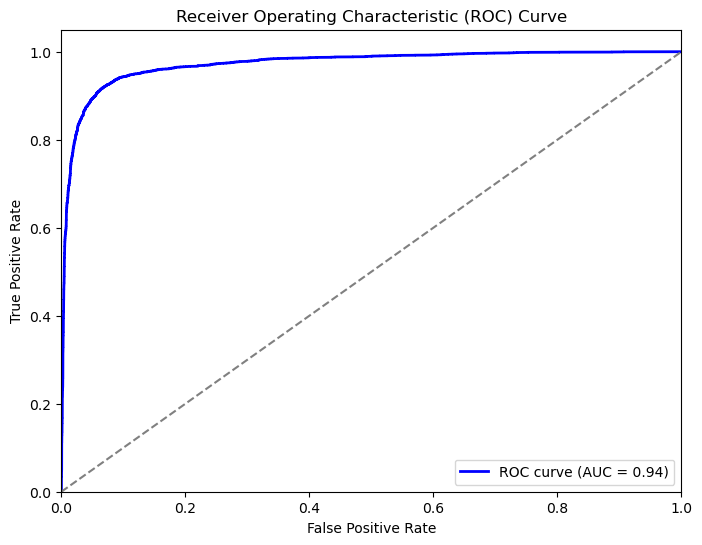

In [39]:
m = novel_model(1024, input_length=MAX_SEQ_LEN, learning_rate=learning_rate)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 